In [36]:
from lstm_model import build_open_loop_lstm, load_open_loop_lstm
from data_processing import create_training_split, df_training_split, train_valid_test_split, df_train_valid_test_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
import tensorflow_datasets as tfds
import tensorflow as tf
import lstm_model
import importlib
import feedback_tf_example
import data_processing
import plot_file
plt.rcParams["figure.facecolor"] = "w"
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
importlib.reload(feedback_tf_example)

<module 'feedback_tf_example' from '/Users/eo821/Documents/PhD_research/Lorenz_LSTM/feedback_tf_example.py'>

In [125]:
mydf = np.genfromtxt('CSV/Lorenz_trans_001.csv', delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
print("Shape of discrete time step array ", time.shape)
print("Shape of solution array: ", mydf.shape)
df_train, df_valid, df_test = df_train_valid_test_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0, :])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])
window_size = 50
batch_size = 32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train.transpose(
), window_size, batch_size, shuffle_buffer_size)
valid_dataset = create_df_3d(df_valid.transpose(), window_size, batch_size, 1)
test_dataset = create_df_3d(df_test.transpose(), window_size, batch_size, 1)

Shape of discrete time step array  (18000,)
Shape of solution array:  (3, 18000)


In [126]:
# only take first element of dataset
for data, labels in train_dataset.take(1):
    numpy_data = data.numpy()
    numpy_labels = labels.numpy()
    

In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
history = model_oloop.fit(train_dataset, epochs=100, batch_size=batch_size,
                          validation_data=valid_dataset, callbacks=[tensorboard_callback])  # , early_stop_callback])

NameError: name 'model_oloop' is not defined

In [127]:
def custom_loss(y_true, y_pred, washout=0):
    mse = tf.keras.losses.MeanSquaredError()
    # (batchsize, dimensions)
    loss = mse(y_true[washout:, :], y_pred[washout:, :])
    return loss

In [134]:
importlib.reload(feedback_tf_example)
feedback_model = feedback_tf_example.FeedBack(units=10)

In [148]:
feedback_model.fit(train_dataset, epochs=1, batch_size=32,
                   validation_data=valid_dataset, verbose=2)

336/336 - 4s - loss: 0.0487 - mse: 0.0487 - mean_squared_error: 0.0000e+00 - val_loss: 0.0097 - val_mse: 0.0097 - val_mean_squared_error: 0.0000e+00 - 4s/epoch - 10ms/step


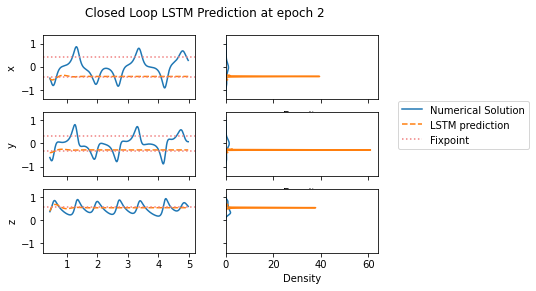

In [130]:
pred = plot_file.plot_closed_loop_lya(
    feedback_model,
    2,
    time_test,
    df_test,
    img_filepath=None,
    n_length=500,
    window_size=50,
)

In [137]:
n_epochs = 0 + 100
n_batches = 2
cloop_size = 32 * n_batches
test_window, labels, idx = lstm_model.select_random_batches_with_label(
    df_train.transpose(), n_batches
)
predictions = feedback_model.predict(np.array(test_window).reshape(cloop_size, 50, 3))
cloop_windows, cloop_label = lstm_model.add_cloop_prediction(
    df_train.transpose(), idx, np.array(predictions).reshape((cloop_size, 1, 3))
)
cloop_dataset = tf.data.Dataset.from_tensor_slices((cloop_windows, cloop_label.reshape(cloop_size,3)))

In [138]:
cloop_dataset = cloop_dataset.padded_batch(32, padded_shapes=([None, 3], [None]))

In [152]:
importlib.reload(feedback_tf_example)
feedback_model = feedback_tf_example.FeedBack(units=10)

In [153]:
feedback_model.train_cloop(train_dataset, cloop_dataset, 5, 2, valid_dataset)

[None, None, None, None, None]


ValueError: No gradients provided for any variable: (['LSTM1/lstm_cell_23/kernel:0', 'LSTM1/lstm_cell_23/recurrent_kernel:0', 'LSTM1/lstm_cell_23/bias:0', 'dense_23/kernel:0', 'dense_23/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'LSTM1/lstm_cell_23/kernel:0' shape=(3, 40) dtype=float32, numpy=
array([[ 0.35775447,  0.19918764, -0.3547633 , -0.24032168,  0.2258479 ,
         0.02238828, -0.06212398,  0.36453015,  0.14506632, -0.13330401,
        -0.2884323 , -0.11053643,  0.05434898,  0.2126826 ,  0.25530314,
         0.269803  , -0.0390445 ,  0.2537269 ,  0.05846781,  0.18515164,
        -0.2630207 , -0.3274622 ,  0.03152502,  0.34572357, -0.21371669,
         0.34155297, -0.35615423,  0.29629964,  0.365268  ,  0.14198661,
        -0.00383037,  0.2437535 , -0.1798298 ,  0.23843229,  0.23477495,
         0.10397467, -0.2502001 , -0.35439298,  0.02451113, -0.17712756],
       [ 0.11650896,  0.22468519,  0.29062742,  0.08245856,  0.18583786,
        -0.2659448 ,  0.09109485, -0.21864739,  0.04275873, -0.0379456 ,
         0.07258344, -0.01718077,  0.28298342, -0.14352514,  0.10377377,
         0.06926605,  0.2535792 ,  0.08352363,  0.02390578,  0.24386793,
         0.31311452,  0.18107808,  0.05045289,  0.23132241, -0.14926629,
        -0.17663114, -0.08059329,  0.15907174,  0.08034322, -0.08220172,
         0.12009138,  0.24124646,  0.32816446,  0.2656923 ,  0.23679233,
        -0.18056643, -0.05251542, -0.00176027,  0.3555659 , -0.04786614],
       [ 0.13763916,  0.09134048, -0.21471496, -0.08127558, -0.18142942,
         0.1282739 ,  0.24544162, -0.09912646,  0.02677128,  0.21155852,
         0.01152283, -0.1625694 ,  0.14896321,  0.12264597, -0.03397194,
         0.04299316,  0.00105038,  0.34412342,  0.06634185, -0.1500355 ,
         0.22165227,  0.15387309,  0.09263042, -0.28739557, -0.15541416,
        -0.32816258,  0.24202895, -0.03616396,  0.04624578, -0.29697865,
        -0.15922494,  0.19969201,  0.2512976 ,  0.21556568,  0.34473962,
         0.19556195,  0.03565943, -0.20219219, -0.35375032,  0.05449086]],
      dtype=float32)>), (None, <tf.Variable 'LSTM1/lstm_cell_23/recurrent_kernel:0' shape=(10, 40) dtype=float32, numpy=
array([[-0.3310027 , -0.15062952,  0.19872524, -0.2047174 , -0.1910967 ,
        -0.10513312,  0.14414214, -0.09607442,  0.16865735, -0.28031686,
         0.26862955, -0.20851132, -0.18318143,  0.13223357, -0.08460928,
         0.01218319,  0.12030546, -0.26199356,  0.20237498,  0.01146162,
        -0.05210112, -0.1096114 , -0.3213539 , -0.20556942,  0.05120039,
        -0.12676863, -0.16921712, -0.01635642,  0.05836628,  0.06891567,
         0.05640736,  0.13945474,  0.00465138,  0.07724962, -0.11391082,
        -0.17327026,  0.08089612, -0.08154594, -0.00594914,  0.05201566],
       [-0.101569  , -0.10654478,  0.00975647, -0.2160688 ,  0.272657  ,
        -0.03726102,  0.1225394 , -0.02733492, -0.37564024, -0.2675799 ,
         0.11954345,  0.14784046,  0.27296987, -0.00435254, -0.10939094,
        -0.02231804, -0.26267242,  0.12488355,  0.02463589, -0.14089096,
         0.16733526, -0.42317837, -0.14574198,  0.13668016,  0.01162833,
         0.0399114 ,  0.11820767, -0.08256705,  0.05884713,  0.12607674,
         0.06544188,  0.11356462,  0.03764087,  0.03659075,  0.11146227,
         0.07265528, -0.05019501,  0.23824303, -0.11005396,  0.03536162],
       [-0.5033625 ,  0.05915703, -0.02697521, -0.06486221,  0.0231695 ,
        -0.03285589, -0.25768483, -0.12300712, -0.03068166,  0.13887268,
        -0.15047428,  0.15671209, -0.1125797 ,  0.17867264, -0.24460143,
        -0.18791513,  0.14890519, -0.07931241,  0.17399396,  0.01832829,
         0.04956077,  0.07524993,  0.14931864,  0.11908112,  0.2931121 ,
         0.17825992, -0.10615567, -0.00791076, -0.0889259 ,  0.08381636,
         0.11879015, -0.05753389, -0.10029667, -0.17665741,  0.311994  ,
         0.18363762,  0.01030002,  0.03773188, -0.08516276, -0.04143403],
       [-0.08696044,  0.05553895,  0.07703195, -0.05259188,  0.1770609 ,
         0.10712254,  0.03720783, -0.21673164,  0.315561  , -0.0181135 ,
         0.02467424, -0.1525116 ,  0.24529374, -0.11338176, -0.14838488,
         0.16914749, -0.14244807, -0.1390143 ,  0.0778629 ,  0.17789185,
         0.14159177, -0.01925844,  0.3915346 , -0.11231866, -0.12230075,
        -0.06356578, -0.02049151, -0.07773511,  0.12505205, -0.11239039,
        -0.00777587, -0.10232551, -0.2604602 ,  0.17955184, -0.06915297,
         0.01839604,  0.13445821,  0.17661175, -0.27783495, -0.28715873],
       [ 0.0399886 ,  0.19995764, -0.14555605, -0.39679146,  0.19138911,
         0.08636316,  0.0595155 ,  0.0794887 ,  0.3181247 ,  0.0398736 ,
        -0.052364  ,  0.16205679, -0.3450014 ,  0.13921566,  0.20152657,
         0.06714968, -0.07732546,  0.05018622,  0.12864614, -0.01260249,
        -0.09914754, -0.17033012, -0.00986351,  0.14458427, -0.07421605,
         0.05719088, -0.03456062,  0.36295444, -0.04652864, -0.07812691,
         0.06561527, -0.05118193,  0.02110003,  0.09442819, -0.1143875 ,
         0.03836312, -0.23334153,  0.07191539, -0.25707158,  0.13760166],
       [-0.06940564, -0.04712209,  0.00703211,  0.06179424,  0.10594115,
        -0.22134407,  0.32772845, -0.04072694, -0.03973997,  0.11193725,
         0.18427368,  0.04919691, -0.16473623,  0.13828157, -0.04307515,
        -0.1504508 , -0.03215397,  0.23402047,  0.08931679, -0.17023452,
         0.16780978,  0.27502474, -0.05540678,  0.34489986, -0.14529762,
        -0.19592753, -0.20075   ,  0.04222899,  0.27560106, -0.12392475,
        -0.0365387 , -0.21376099, -0.09316952, -0.00388426, -0.15001833,
         0.19050026,  0.2102722 ,  0.05276962,  0.12720916, -0.0969381 ],
       [ 0.04917743,  0.23496053, -0.08662831,  0.05956008, -0.03123757,
        -0.10527717, -0.05927733, -0.02810366, -0.01010567,  0.00812862,
         0.00636372, -0.49730816, -0.03726753, -0.05171257, -0.00447088,
         0.0212114 , -0.0365442 , -0.1394023 ,  0.29316482, -0.09913684,
        -0.04688876, -0.05385834,  0.05107675,  0.18694709,  0.09318437,
        -0.14751178,  0.24329352, -0.08675293, -0.05798432,  0.2500499 ,
         0.05596041, -0.2826684 ,  0.00735447,  0.22531845,  0.03019565,
         0.15556996, -0.19007587,  0.20526713,  0.26644173,  0.18008916],
       [ 0.03040532, -0.28048185, -0.18816309, -0.1898345 , -0.16351841,
         0.2625081 , -0.1247146 , -0.2634183 , -0.04672755,  0.04346524,
        -0.22163315, -0.09286326,  0.02975098,  0.01594807, -0.20953645,
        -0.10263924, -0.11680731, -0.03149143,  0.03449431, -0.04823934,
        -0.03997901,  0.12388629, -0.07464373,  0.26478177, -0.14492635,
        -0.3974739 ,  0.09786128,  0.01904661,  0.06820431, -0.24428776,
         0.04863689,  0.17042515, -0.12754281, -0.08848023,  0.07237242,
        -0.22347298, -0.27202407, -0.03039787,  0.03384961,  0.01364075],
       [-0.16257602,  0.2382975 , -0.23398152, -0.11820431,  0.01502723,
         0.10592038, -0.01971776,  0.05565399, -0.07247378,  0.00679546,
         0.05365183,  0.06824385,  0.01594823, -0.05418892,  0.03012313,
         0.2642106 , -0.02104277, -0.19696686, -0.28492045, -0.02081142,
         0.02362973, -0.11058958,  0.21263207,  0.1575962 ,  0.06145005,
        -0.18933581, -0.40412858, -0.26118535,  0.12164931,  0.18690215,
        -0.05304205,  0.14758614, -0.03545909, -0.16690692, -0.2849923 ,
         0.08453941, -0.11237696, -0.1354968 ,  0.19216517,  0.10870927],
       [ 0.12150215,  0.20743297,  0.21426193, -0.18038654,  0.12462577,
        -0.12892883, -0.03437259,  0.09185435, -0.10451803, -0.00505468,
        -0.03606756,  0.22340396, -0.07724807, -0.15786897, -0.1179743 ,
        -0.13499373, -0.11817728, -0.39100295,  0.02255779, -0.11154163,
         0.07599843,  0.18006793, -0.1452396 ,  0.14575706, -0.14833884,
         0.03043069,  0.04679187, -0.10511611, -0.4478951 ,  0.04596292,
         0.06842721, -0.0288596 , -0.15167038,  0.05138669, -0.17980193,
        -0.17026897,  0.00537527, -0.07065237,  0.08990233, -0.30328727]],
      dtype=float32)>), (None, <tf.Variable 'LSTM1/lstm_cell_23/bias:0' shape=(40,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_23/kernel:0' shape=(10, 3) dtype=float32, numpy=
array([[ 0.3685912 , -0.08287179,  0.15378207],
       [ 0.00983453,  0.06320727,  0.30819273],
       [ 0.29148144,  0.02805966,  0.20845217],
       [-0.48415345, -0.4709251 , -0.55244637],
       [-0.3632501 ,  0.01605499, -0.17063212],
       [-0.03485024, -0.48978364,  0.55788314],
       [-0.29781651,  0.34152496, -0.01084006],
       [ 0.40648925, -0.501235  ,  0.5390972 ],
       [-0.20434257,  0.01337707,  0.33526075],
       [-0.36052766, -0.09407002,  0.2781021 ]], dtype=float32)>), (None, <tf.Variable 'dense_23/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>)).

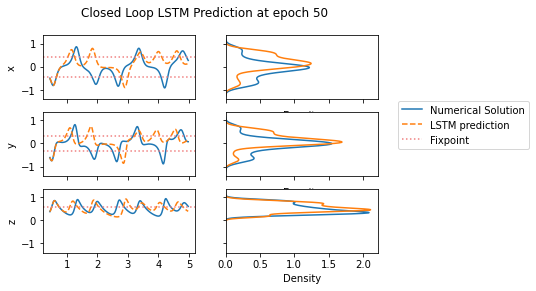

In [108]:
pred = plot_file.plot_closed_loop_lya(
    feedback_model,
    50,
    time_test,
    df_test,
    img_filepath=None,
    n_length=500,
    window_size=50,
)